In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.cluster.hierarchy as hac
from scipy.cluster.hierarchy import fcluster

import sys  
sys.path.insert(0, '../../common/Cluster')
from plot_pie import plot_pie

from matplotlib.ticker import FixedLocator, FixedFormatter

# **K-means compared to feature based (quantity)**

NB: see rather notebook k_means_vs_feature_based_cons in common->Results->feature_based, as the method for selecting features used in this notebook was replaced by consumption based labeling.
<br>
<br>
The data used in this notebook is the same  both k-means and feature based.

In [3]:
bolighus_hour_avg_week = pd.read_parquet('../parquet_files/df_bolighus_quantity.parquet')
hytte_hour_avg_week = pd.read_parquet('../parquet_files/df_hytte_quantity.parquet')
naering_hour_avg_week = pd.read_parquet('../parquet_files/df_naering_quantity.parquet')

In [4]:
df = pd.read_parquet('../parquet_files/weekly_load_all_trafos.parquet')

In [5]:
df.shape

(168, 5444)

In [6]:
with open('../txt_files/list_bolighus_hytte_naering_quantity_based.txt') as f:
    wanted_trafos = f.read().splitlines()

In [7]:
possible_trafos = [x for x in df.columns if x in wanted_trafos]

In [8]:
df_feature_equ = df[possible_trafos]

In [9]:
x = df_feature_equ.T.iloc[:,:].values

In [10]:
weekly_t=df_feature_equ.transpose()

In [11]:
km1 = KMeans(n_clusters=3)

y_km1 = km1.fit_predict(weekly_t)

In [12]:
c1=weekly_t.loc[y_km1 == 0].transpose()
c2=weekly_t.loc[y_km1 == 1].transpose()
c3=weekly_t.loc[y_km1 == 2].transpose()

In [13]:
label_kmeans = []
for idx in df_feature_equ.T.index:
    if idx in list(c1.columns):
        label_kmeans.append(1)
    elif idx in list(c2.columns):
        label_kmeans.append(2)
    elif idx in list(c3.columns):
        label_kmeans.append(3)
    else:
        print("ERROR: ", idx)

In [14]:
label_feature = []
for idx in df_feature_equ.T.index:
    if idx in list(bolighus_hour_avg_week.columns):
        label_feature.append(1)
    elif idx in list(hytte_hour_avg_week.columns):
        label_feature.append(2)
    elif idx in list(naering_hour_avg_week.columns):
        label_feature.append(3)
    else:
        print("ERROR: ", idx)

### **Cluster centroids**

Note: the k-means resulting clusters are manual mapped to the feature based clusters. If this notebook is re-run, there might arise a mismatch. 


K-means centroids



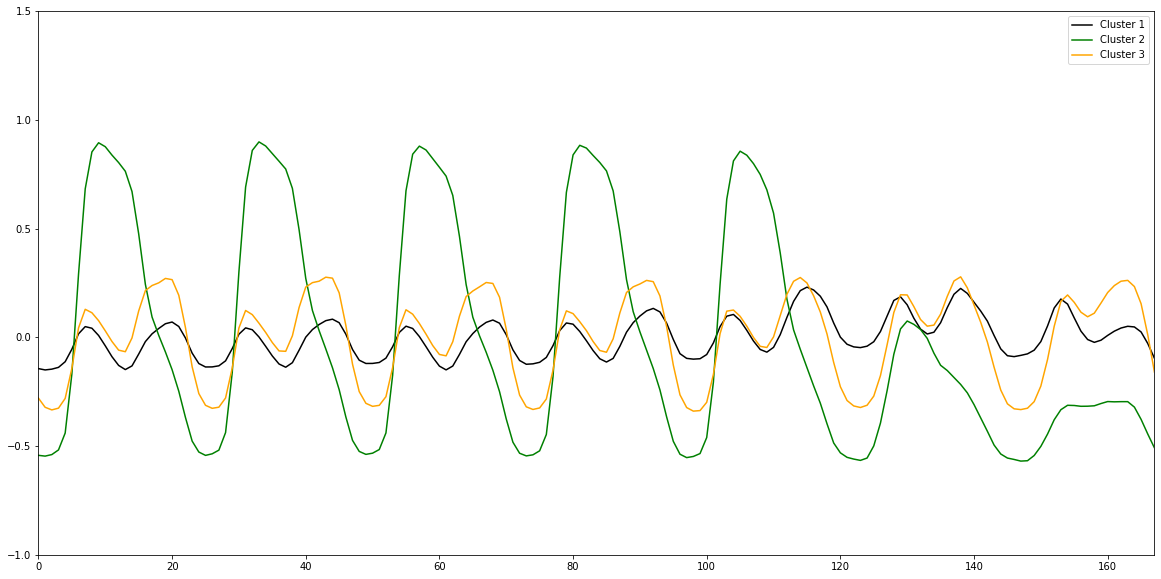

In [15]:
plt.figure(figsize=(20,10))
plt.plot(c1.mean(axis=1),color="k", label ='Cluster 1')
plt.plot(c2.mean(axis=1), color = 'green', label = 'Cluster 2')
plt.plot(c3.mean(axis=1), color='orange', label='Cluster 3')
plt.ylim(-1,1.5)
plt.xlim(0,167)
plt.legend()
plt.show
print("\nK-means centroids\n")


Feature based centroids



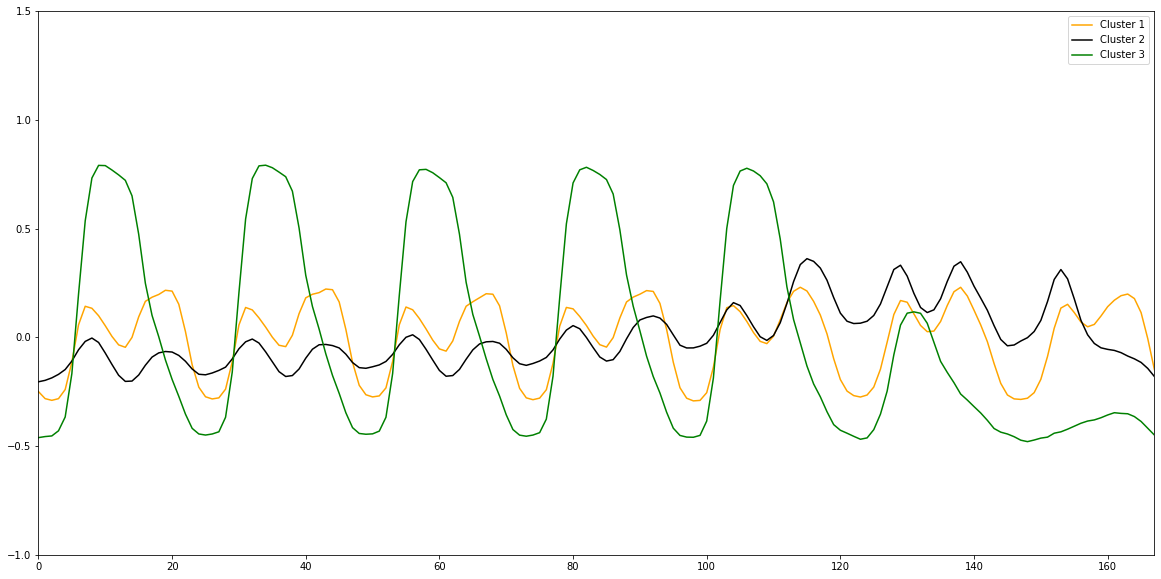

In [16]:
plt.figure(figsize=(20,10))
plt.plot(bolighus_hour_avg_week.mean(axis=1),color="orange", label ='Cluster 1')
plt.plot(hytte_hour_avg_week.mean(axis=1), color = 'k', label = 'Cluster 2')
plt.plot(naering_hour_avg_week.mean(axis=1), color='green', label='Cluster 3')
plt.ylim(-1,1.5)
plt.xlim(0,167)
plt.legend()
plt.show
print("\nFeature based centroids\n")

## **Evaluation, scoring**

See common -> Results -> data_driven_clustering -> datadriven_clustering_results for a detailed description of each scoring metric. Included here is a short summary to help understand the results. 
The text description used here does not comply with copyright rules, and must be changed/removed if to be published. 

### **silhouette_score**

The Silhouette score is a measure of how well samples are clustered with samples that are similar to themselves. Clustering models with a high Silhouette score are said to be dense, where samples in the same cluster are similar to each other, and well separated, where samples in different clusters are not very similar to each other. 

In [17]:
from sklearn.metrics import silhouette_score

In [18]:
silhouette_score_k_means = silhouette_score(x, labels=label_kmeans, metric='euclidean')

In [19]:
silhouette_score_feature = silhouette_score(x, labels=label_feature, metric='euclidean')

In [20]:
print("K-means silhouette_score: ", silhouette_score_k_means)
print("Feature based silhouette_score: ", silhouette_score_feature)

K-means silhouette_score:  0.23625349483078056
Feature based silhouette_score:  0.187836347821496


## **davies_bouldin_score**

This index signifies the average ‘similarity’ between clusters, where the similarity is a measure that compares the distance between clusters with the size of the clusters themselves. Zero is the lowest possible score. Values closer to zero indicate a better partition.

In [21]:
from sklearn.metrics import davies_bouldin_score

In [22]:
davies_bouldin_score_k_means = davies_bouldin_score(x, labels=label_kmeans)

In [23]:
davies_bouldin_score_feature = davies_bouldin_score(x, labels=label_feature)

In [24]:
print("K-means davies_bouldin_score: ", davies_bouldin_score_k_means)
print("Feature based davies_bouldin_score: ", davies_bouldin_score_feature)

K-means davies_bouldin_score:  1.2850899500147446
Feature based davies_bouldin_score:  1.3097804896404996


## **calinski_harabasz_score**

A higher Calinski-Harabasz score relates to a model with better defined clusters. The index is the ratio of the sum of between-clusters variation and of inter-cluster variation for all cluster.

In [25]:
from sklearn.metrics import calinski_harabasz_score

In [26]:
calinski_harabasz_score_k_means = calinski_harabasz_score(x, labels=label_kmeans)

In [27]:
calinski_harabasz_score_feature = calinski_harabasz_score(x, labels=label_feature)

In [28]:
print("K-means calinski_harabasz_score: ", calinski_harabasz_score_k_means)
print("Feature based calinski_harabasz_score: ", calinski_harabasz_score_feature)

K-means calinski_harabasz_score:  2403.574554625151
Feature based calinski_harabasz_score:  614.7718973050687


### **House cluster**

In [29]:
print("Nr. of ns in feature based house cluster: ",len(bolighus_hour_avg_week.columns))
print("Nr. of ns in k-means house cluster: ",len(c3.columns))

Nr. of ns in feature based house cluster:  4651
Nr. of ns in k-means house cluster:  3204


Feature based: 


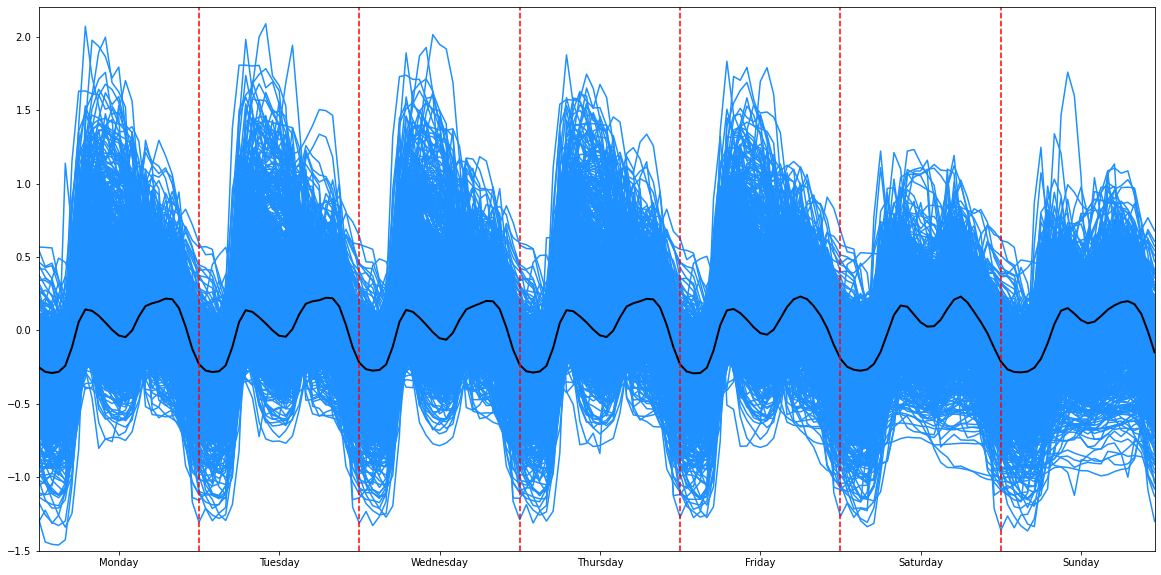

In [30]:
fig, ax = plt.subplots(figsize=(20,10))
bolighus_hour_avg_week.plot(ax=ax, legend=False,color="dodgerblue")
bolighus_hour_avg_week.mean(axis=1).plot(color='k', linewidth=2)

x_formatter = FixedFormatter(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
x_locator = FixedLocator([12,36,60,84,108,132,156])
ax.xaxis.set_major_formatter(x_formatter)
ax.xaxis.set_major_locator(x_locator)
ax.set_xlim(0,167)
ax.set_ylim(-1.5,2.2)

xposition = [24,48,72,96,120,144]
for xc in xposition:
    plt.axvline(x=xc, color='r', linestyle='--')
    
print('Feature based: ')

K-means result: 


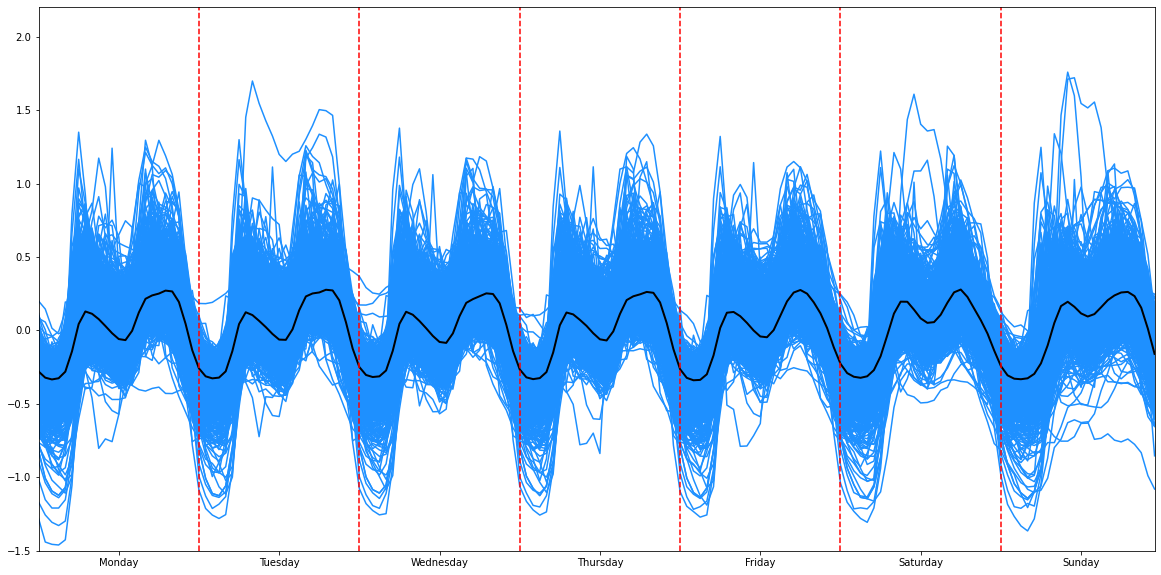

In [31]:
fig, ax = plt.subplots(figsize=(20,10))
c3.plot(ax=ax, legend=False,color="dodgerblue")
c3.mean(axis=1).plot(color='k', linewidth=2)

x_formatter = FixedFormatter(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
x_locator = FixedLocator([12,36,60,84,108,132,156])
ax.xaxis.set_major_formatter(x_formatter)
ax.xaxis.set_major_locator(x_locator)
ax.set_xlim(0,167)
ax.set_ylim(-1.5,2.2)

xposition = [24,48,72,96,120,144]
for xc in xposition:
    plt.axvline(x=xc, color='r', linestyle='--')
    
print('K-means result: ')

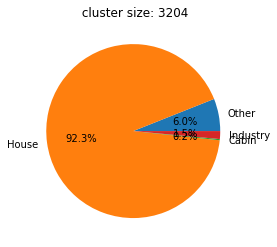

In [41]:
plot_pie(c3, file_path='../parquet_files/')

### **Cabin cluster**

In [33]:
print("Nr. of ns in feature based cabin cluster: ",len(hytte_hour_avg_week.columns))
print("Nr. of ns in k-means cabin cluster: ",len(c1.columns))

Nr. of ns in feature based cabin cluster:  537
Nr. of ns in k-means cabin cluster:  1788


Feature based: 


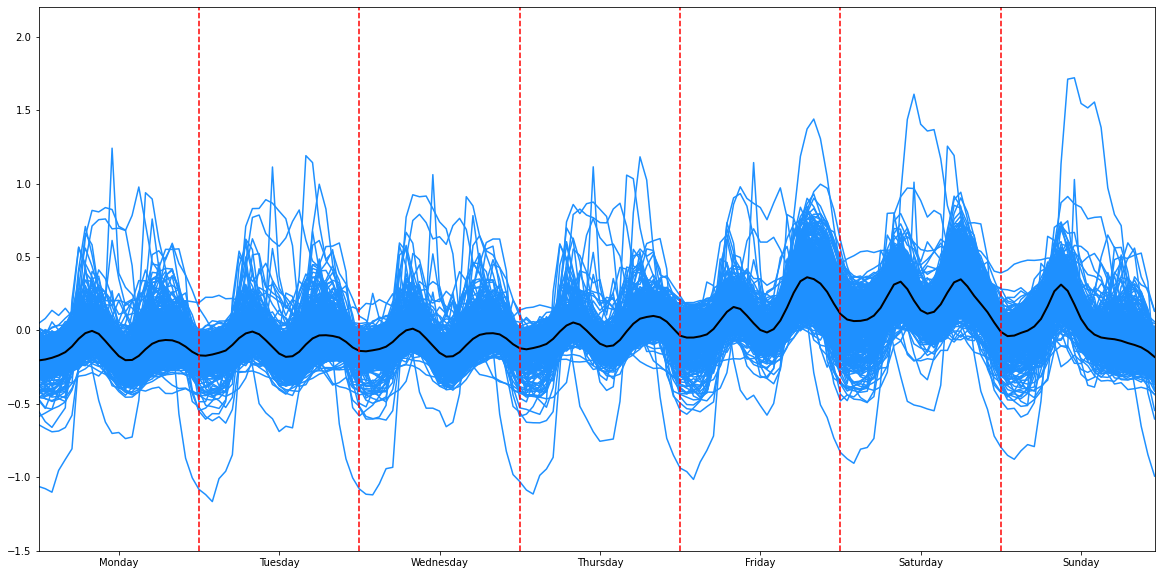

In [34]:
fig, ax = plt.subplots(figsize=(20,10))
hytte_hour_avg_week.plot(ax=ax, legend=False,color="dodgerblue")
hytte_hour_avg_week.mean(axis=1).plot(color='k', linewidth=2)

x_formatter = FixedFormatter(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
x_locator = FixedLocator([12,36,60,84,108,132,156])
ax.xaxis.set_major_formatter(x_formatter)
ax.xaxis.set_major_locator(x_locator)
ax.set_xlim(0,167)
ax.set_ylim(-1.5,2.2)

xposition = [24,48,72,96,120,144]
for xc in xposition:
    plt.axvline(x=xc, color='r', linestyle='--')
    
print('Feature based: ')

K-means result: 


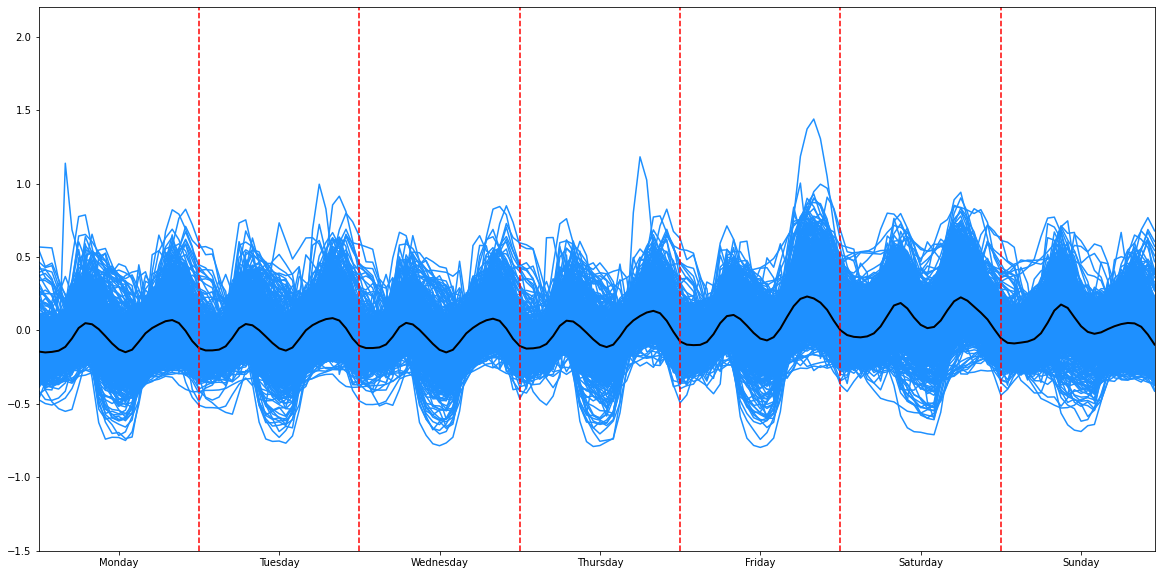

In [35]:
fig, ax = plt.subplots(figsize=(20,10))
c1.plot(ax=ax, legend=False,color="dodgerblue")
c1.mean(axis=1).plot(color='k', linewidth=2)

x_formatter = FixedFormatter(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
x_locator = FixedLocator([12,36,60,84,108,132,156])
ax.xaxis.set_major_formatter(x_formatter)
ax.xaxis.set_major_locator(x_locator)
ax.set_xlim(0,167)
ax.set_ylim(-1.5,2.2)

xposition = [24,48,72,96,120,144]
for xc in xposition:
    plt.axvline(x=xc, color='r', linestyle='--')
    
print('K-means result: ')

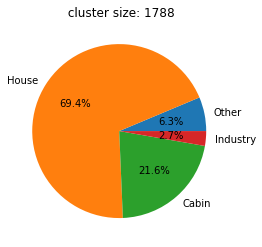

In [36]:
plot_pie(c1, file_path='../parquet_files/')

### **Industry cluster**

In [37]:
print("Nr. of ns in feature based industry cluster: ",len(naering_hour_avg_week.columns))
print("Nr. of ns in k-means hoindustry use cluster: ",len(c2.columns))

Nr. of ns in feature based industry cluster:  129
Nr. of ns in k-means hoindustry use cluster:  325


Feature based: 


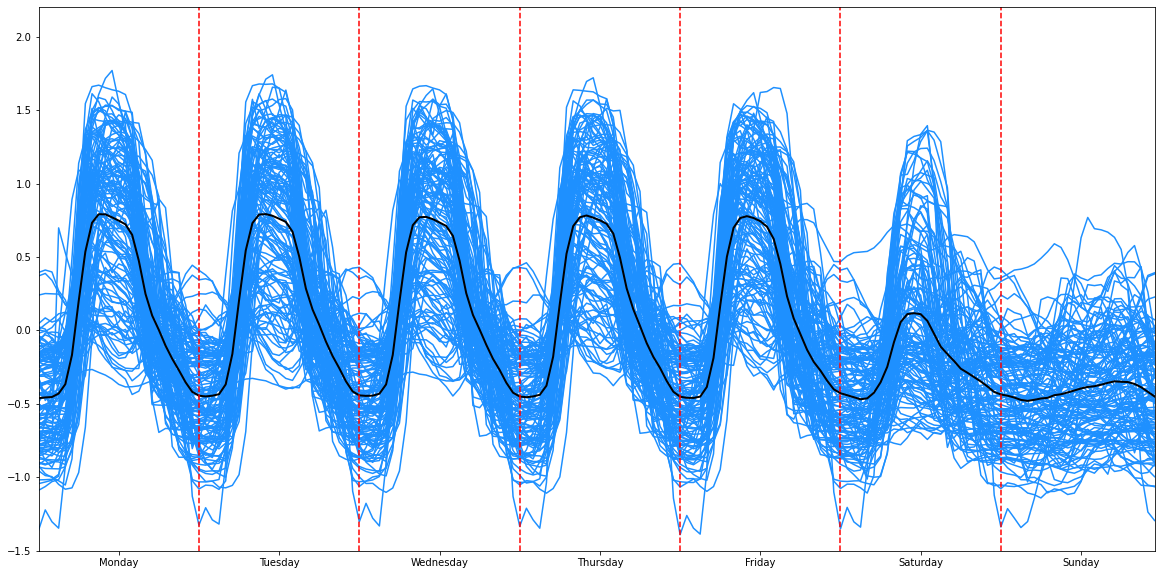

In [38]:
fig, ax = plt.subplots(figsize=(20,10))
naering_hour_avg_week.plot(ax=ax, legend=False,color="dodgerblue")
naering_hour_avg_week.mean(axis=1).plot(color='k', linewidth=2)

x_formatter = FixedFormatter(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
x_locator = FixedLocator([12,36,60,84,108,132,156])
ax.xaxis.set_major_formatter(x_formatter)
ax.xaxis.set_major_locator(x_locator)
ax.set_xlim(0,167)
ax.set_ylim(-1.5,2.2)

xposition = [24,48,72,96,120,144]
for xc in xposition:
    plt.axvline(x=xc, color='r', linestyle='--')
    
print('Feature based: ')

K-means result: 


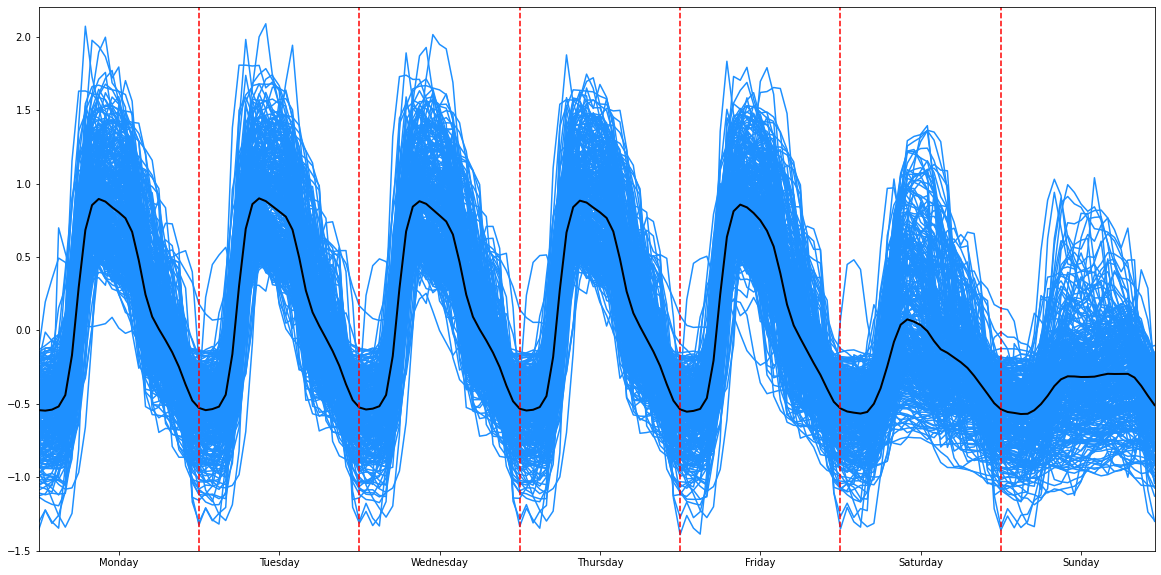

In [39]:
fig, ax = plt.subplots(figsize=(20,10))
c2.plot(ax=ax, legend=False,color="dodgerblue")
c2.mean(axis=1).plot(color='k', linewidth=2)

x_formatter = FixedFormatter(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
x_locator = FixedLocator([12,36,60,84,108,132,156])
ax.xaxis.set_major_formatter(x_formatter)
ax.xaxis.set_major_locator(x_locator)
ax.set_xlim(0,167)
ax.set_ylim(-1.5,2.2)

xposition = [24,48,72,96,120,144]
for xc in xposition:
    plt.axvline(x=xc, color='r', linestyle='--')
    
print('K-means result: ')

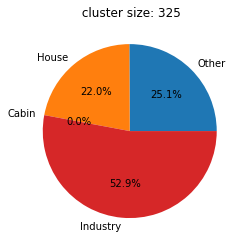

In [42]:
plot_pie(c2, file_path='../parquet_files/')